# Подключение к Postgres

In [16]:
import datetime
import logging
import os
from subprocess import call

import numpy as np
import pandas as pd
from sqlalchemy import create_engine


logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
# движок нужен для подключения к Postgres
engine = create_engine('postgresql://postgres:@{}'.format(os.environ['APP_POSTGRES_HOST']))

Считываем таблицу с оценками в Pandas DataFrame

In [17]:
ratings = pd.read_sql('SELECT * FROM ratings', engine)

Смотрим, что выгрузилось

In [18]:
ratings.head()

,userid,movieid,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


Магия pandas - аггрегируем оценки

In [19]:
ratings_agg = ratings.groupby(
    ratings.movieid
).agg(
    {'userid': 'count'}
).sort_values(
    'userid',
    ascending=False
)
ratings_agg.columns = ['user_count']
ratings_agg = ratings_agg.reset_index()

ratings_agg.head()

,user_count
movieid,
318,2813
356,2732
296,2621
593,2524
2571,2359


пример графики

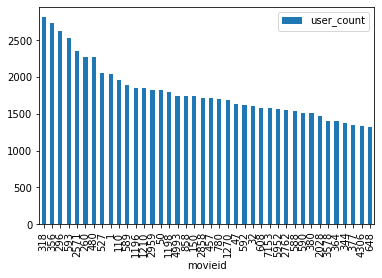

In [20]:
%matplotlib inline

ratings_agg.head(40).plot.bar()

# Подключение к Mongo

In [21]:
import os

from pymongo import MongoClient

In [22]:
mongo = MongoClient(**{
    'host': os.environ['APP_MONGO_HOST'],
    'port': int(os.environ['APP_MONGO_PORT'])
})
db = mongo["movie"]
collection = db['tags']

In [44]:
movies_with_tags = list({i['movie_id'] for i in collection.find({}, {'_id': 0, 'movie_id': 1})})
print(f"Количество фильмов с тэгами {len(movies_with_tags)}")

Количество фильмов с тэгами 42994


Трансформируем то, что достали из Mongo в DataFrame

In [71]:
def value2int(x):
    try:
        return int(x)
    except ValueError:
        return -1

movies_with_tags_df = pd.DataFrame({'movie_id': movies_with_tags})
movies_with_tags_df[
    'movie_id'
] = movies_with_tags_df[
    'movie_id'
].astype(
    dtype=np.uint32, errors = 'ignore'
).apply(value2int)

movies_with_tags_df.head(5)

,movie_id
0,5742
1,204349
2,42231
3,420648
4,12281


Отфильтровываем популярные фильмы, у которых отсутствуют тэги

In [72]:
ratings_agg = ratings_agg.merge(
    movies_with_tags_df,
    how='inner',
    left_on='movieid', right_on='movie_id'
)[['movieid', 'user_count']]

ratings_agg.head(3)

,movieid,user_count
0,318,2813
1,296,2621
2,593,2524


Смотрим, какой жанр у самого популярного контента

In [73]:
most_popular_movie_id = ratings_agg.movieid.values[1]

doc = collection.find({'movie_id': f'{most_popular_movie_id}'}, {'_id': 0}).limit(1)
[i for i in doc]

[{'movie_id': '296', 'tag_id': 28, 'tag_name': 'Action'}]

# Подключение к Redis